In [86]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

Задача распределения температуры в стержне:
$$
c\rho \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left[ \lambda \frac{\partial T}{\partial x} \right] + Q(x_1, t)
$$
Начальные условия:
$$
T(x, 0) = T_0 = const
$$
Граничные условия:
$$
T(0, t) = T_1(t)
$$
$$
T(x_{max}, t) = T_2 = const
$$
Функция источника:
$$
Q(x_1, t) = Q_1 = const
$$
Распределение:

a) $\lambda(x) = f(x)$ -- непрерывная.

b) $\lambda(x, T)$ -- линейная зависимость от $T$.


Обезразмеривание:
$$
\xi = x/l
$$
$$
\tau = \frac{t}{c \rho l^2}
$$
Итого:
$$
\frac{\partial T}{\partial \tau} = \frac{\partial}{\partial \xi} \left[ a(\xi, T) \frac{\partial T}{\partial \xi} \right] + Q'(\xi_1, \tau)
$$
где 
$$
Q'(\xi_1, \tau) = Q(\xi l, c\rho l^2 \tau) l^2
$$
$$
a(\xi, T) = \lambda(\xi l, T)
$$
Начальные и граничные условия:
$$
T(\xi, 0) = T_0 = const
$$
$$
T'(0, \tau) = T_1(c\rho l^2 \tau)
$$
$$
T(1, \tau) = T_2 = const
$$

In [87]:
# физические параметры задачи
c = 1.
rho = 1.
x_max = 1.

lamb_k = 1.

In [88]:
# шаг по пространству
h = 0.05
h_ = h * x_max
N = int(1/h) + 1
print(N)

21


In [89]:
# Начальные условия, функции распределения
T_0 = 2.
T_1_max = 1.
def T_1(t):
    if (t < 0.03):
        return T_1_max/3
    elif (t < 0.06):
        return T_1_max*2/3
    else:
        return T_1_max
    
T_2 = 3.

x_1 = 0.5

Q_1_max = 500
def Q_1(x, t):
    if ((x < x_1 + h_) and (x > x_1 - h_)):
        if (t < 0.03):
            return Q_1_max/3
        elif (t < 0.06):
            return Q_1_max*2/3
        else:
            return Q_1_max
    else:
        return 0.

In [90]:
lamb_x = np.ones(N)
lamb_x[0] = 0.5 + np.random.rand(1)
for i in range(1, N):
    dif = (np.random.rand(1) - 0.5)/10
    lamb_x[i] = abs(lamb_x[i-1] + dif)

def lamb(x, T):
    index = int(x/h_)
    return lamb_x[index] + lamb_k * T

lamb_0 = max(lamb_x) + lamb_k * max(T_0, T_1_max, T_2)
# попытка оценить температуру, которую может дать источник Q_1
d_lamb = 0
while (d_lamb > 0.0001 * lamb_0):
    dt_1 = h * h / (2 * lamb_0)
    d_lamb = lamb_k * dt_1 *Q_1_max
    lamb_0 += d_lamb
print(lamb_0)

4.513098912132338


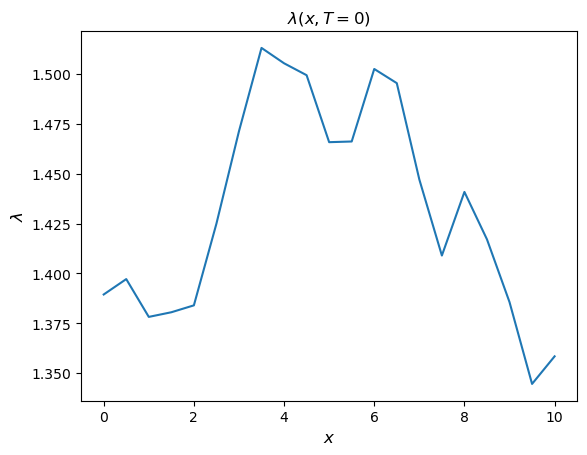

In [91]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 10, N), lamb_x)
plt.title('$\lambda(x, T=0)$', fontsize=12)
plt.ylabel('$\lambda$', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.show()

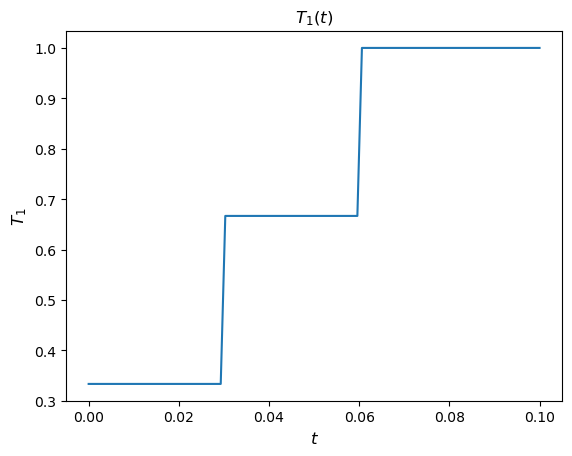

In [92]:
T_1_arr = np.zeros(100)
for i in range(100):
    T_1_arr[i] = T_1(np.linspace(0, 0.1, 100)[i])
plt.plot(np.linspace(0, 0.1, 100), T_1_arr)
plt.title('$T_1(t)$', fontsize=12)
plt.ylabel('$T_1$', fontsize=12)
plt.xlabel('$t$', fontsize=12)
plt.show()

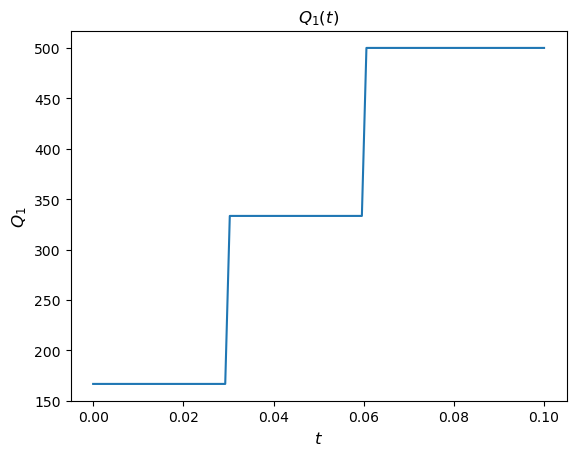

In [93]:
Q_1_arr = np.zeros(100)
for i in range(100):
    Q_1_arr[i] = Q_1(x_1, np.linspace(0, 0.1, 100)[i])
plt.plot(np.linspace(0, 0.1, 100), Q_1_arr)
plt.title('$Q_1(t)$', fontsize=12)
plt.ylabel('$Q_1$', fontsize=12)
plt.xlabel('$t$', fontsize=12)
plt.show()

In [94]:
# шаг по времени определяем из условия Куранта
dt = h * h / (2 * lamb_0)
r = dt/h/h
dt_ = dt * c * rho * x_max**2
time = 0.2
M = int(time/dt) + 1
print(dt_)
print(M)

0.00027697154977917454
723


Разностная схема (явная):
$$
T^{n+1}_k-T^n_k = r [a_{k+1/2} T^{n}_{k+1} - (a_{k+1/2}+a_{k-1/2})T^{n}_k + a_{k-1/2}T^{n}_{k-1}] + \Delta\tau Q_k^{'n}
$$
Для независимого от температуры коэффициента теплопроводности:
$$
a_{k \pm 1/2} = a(\xi_k \pm h/2, \tau^{n})
$$
Для зависимого от температуры коэффициента теплопроводности:
$$
a_{k \pm 1/2} = 0.5[a(\xi_{k\pm 1}, \tau^{n}, T_{k \pm 1}^n) + a(\xi_{k}, \tau^{n}, T_{k}^n)]
$$

In [95]:
def step_ex(T_pre, T_cur, T_nxt, xi, tau):
    #print("T_pre = ", T_pre)
    #print("T_cur = ", T_cur)
    #print("T_nxt = ", T_nxt)
    #print("r = ", r)
    x = xi * x_max
    t = tau * rho * c * x_max**2
    a_pre = 0.5 * (lamb(x - h_, T_pre) + lamb(x, T_cur))
    #print("a_pre = ", a_pre)
    a_nxt = 0.5 * (lamb(x + h_, T_nxt) + lamb(x, T_cur))
    #print("a_nxt = ", a_nxt)
    return T_cur + r * (a_nxt * T_nxt - (a_nxt + a_pre) * T_cur + a_pre * T_pre) + dt * Q_1(x, t)

In [96]:
T_arr = np.zeros([N, M])
# init cond
for i in range(N):
    T_arr[i][0] = T_0
# bound cond
for i in range(M):
    T_arr[0][i] = T_1(dt_*i)
    T_arr[N-1][i] = T_2
    
for i in range(M - 1):
    tau = dt * i
    for j in range(1, N - 1):
        xi = h * j
        T_arr[j][i + 1] = step_ex(T_arr[j-1][i], T_arr[j][i], T_arr[j+1][i], xi, tau)
        #print(T_arr[j][i + 1])

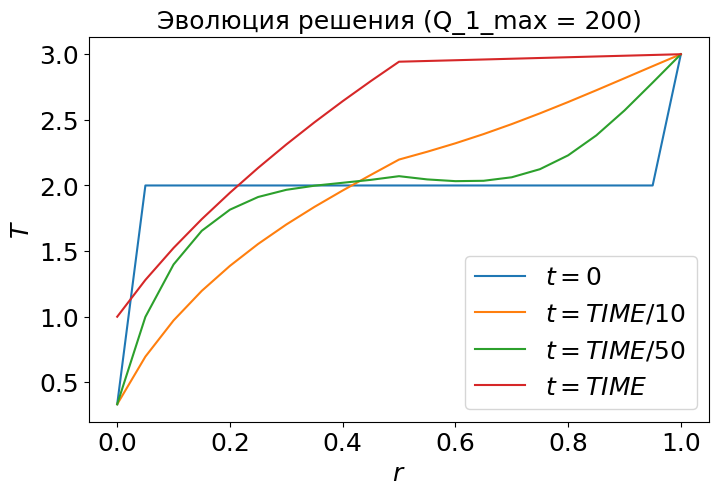

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, x_max, N), T_arr[:, 0])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//10])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//50])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M-1])
plt.title('Эволюция решения (Q_1_max = 200)', fontsize=18)
plt.ylabel('$T$', fontsize=18)
plt.xlabel('$r$', fontsize=18)
plt.legend(['$t = 0$','$t = TIME/10$','$t = TIME/50$','$t = TIME$'],fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

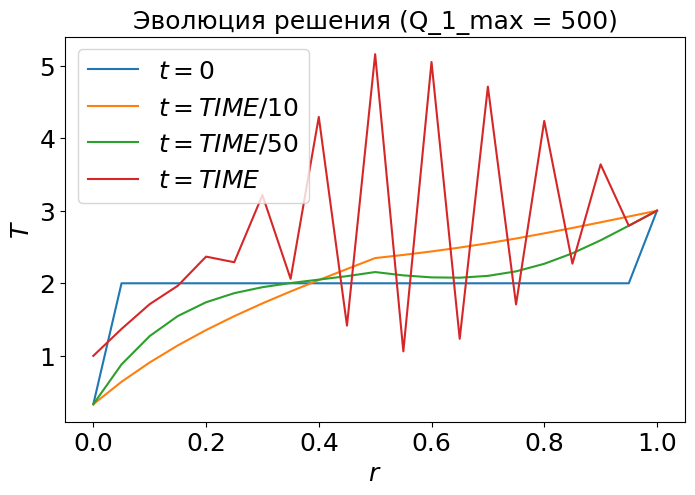

In [97]:
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, x_max, N), T_arr[:, 0])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//10])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//50])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M-1])
plt.title('Эволюция решения (Q_1_max = 500)', fontsize=18)
plt.ylabel('$T$', fontsize=18)
plt.xlabel('$r$', fontsize=18)
plt.legend(['$t = 0$','$t = TIME/10$','$t = TIME/50$','$t = TIME$'],fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Флуктуации связаны с появлением неустойчивости (несоблюдение условия Куранта).

Разностная схема (неявная, позволит избежать неусточивость):
$$
T^{n+1}_k-T^n_k = r [a_{k+1/2} T^{n+1}_{k+1} - (a_{k+1/2}+a_{k-1/2})T^{n+1}_k + a_{k-1/2}T^{n+1}_{k-1}] + \Delta\tau Q_k^{'n}
$$
Для независимого от температуры коэффициента теплопроводности:
$$
a_{k \pm 1/2} = a(\xi_k \pm h/2, \tau^{n+1})
$$
Для зависимого от температуры коэффициента теплопроводности:
$$
a_{k \pm 1/2} = 0.5[a(\xi_{k\pm 1}, \tau^{n+1}, T_{k \pm 1}^n) + a(\xi_{k}, \tau^{n+1}, T_{k}^n)]
$$

Метод прогонки:
$$
\begin{array}{l}
A_k T^{n+1}_{k-1} - B_k T^{n+1}_k + C_k T^{n+1}_{k+1} = D_k
\\
A_k = ra_{k-1/2}
\\
B_k = 1 + r(a_{k+1/2} + a_{k-1/2})
\\
C_k = ra_{k+1/2}
\\
D_k = - T_k^n - \Delta Q{'n}_k
\end{array}
$$
Прогоночные коэффициенты:
$$
P_{k+1} = \frac{C_k}{B_k-A_k P_k}
$$
$$
Q_{k+1} = \frac{A_k Q_k-D_k}{B_k - A_k P_k}
$$

Прогоночное соотношение:
$$
T_{k}^{n+1} = P_{k+1} T_{k+1}^{n+1} + Q_{k+1}
$$
Из правого граничного условия:
$$
T_N^n = T_2
$$
Из левого граничного условия:
$$
P_1 = 0, Q_1 = T_1^{n+1} = T_1([n+1] \Delta \tau)
$$

In [98]:
def A_k(xi, T_pre, T_cur):
    x = xi * x_max
    a_pre = 0.5 * (lamb(x - h_, T_pre) + lamb(x, T_cur))
    return r * a_pre

def B_k(xi, T_pre, T_cur, T_nxt):
    x = xi * x_max
    a_pre = 0.5 * (lamb(x - h_, T_pre) + lamb(x, T_cur))
    a_nxt = 0.5 * (lamb(x + h_, T_nxt) + lamb(x, T_cur))
    return + 1 + r * (a_pre + a_nxt)

def C_k(xi, T_cur, T_nxt):
    x = xi * x_max
    a_nxt = 0.5 * (lamb(x + h_, T_nxt) + lamb(x, T_cur))
    return r * a_nxt

def D_k(xi, tau, T_cur):
    x = xi * x_max
    t = tau * rho * c * x_max**2
    return - T_cur - dt * Q_1(x, t)

def P_nxt(P_pre, xi, T_pre, T_cur, T_nxt):
    return C_k(xi, T_cur, T_nxt)/(B_k(xi, T_pre, T_cur, T_nxt) - A_k(xi, T_pre, T_cur) * P_pre)

def Q_nxt(P_pre, Q_pre, xi, tau, T_pre, T_cur, T_nxt):
    return (A_k(xi, T_pre, T_cur) * Q_pre - D_k(xi, tau, T_cur))/(B_k(xi, T_pre, T_cur, T_nxt) - A_k(xi, T_pre, T_cur) * P_pre)

def T_pre(T_cur, Q_cur, P_cur):
    return P_cur * T_cur + Q_cur

In [99]:
T_arr = np.zeros([N, M])
# init cond
for i in range(N):
    T_arr[i][0] = T_0
# bound cond
for i in range(M):
    T_arr[0][i] = T_1(dt_*i)
    T_arr[N-1][i] = T_2

In [100]:
for i in range(M-1):
    tau = dt * i
    Q_arr = np.zeros(N)
    P_arr = np.zeros(N)
    Q_arr[1] = T_1(dt_*i)
    P_arr[1] = 0
    for j in range(1, N-1):
        xi = h * j
        Q_arr[j+1] = Q_nxt(P_arr[j], Q_arr[j], xi, tau, T_arr[j-1][i], T_arr[j][i], T_arr[j+1][i])
        P_arr[j+1] = P_nxt(P_arr[j], xi, T_arr[j-1][i], T_arr[j][i], T_arr[j+1][i])
    for j in range(1, N):
        T_arr[N-1-j][i+1] = T_pre(T_arr[N-j][i+1], Q_arr[N-j], P_arr[N-j])
        #print(Nh-1-j)

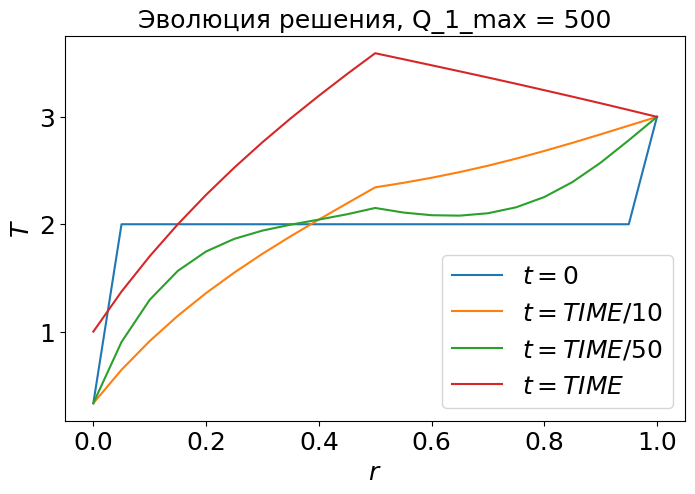

In [102]:
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, x_max, N), T_arr[:, 0])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//10])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M//50])
plt.plot(np.linspace(0, x_max, N), T_arr[:, M-1])
plt.title('Эволюция решения, Q_1_max = 500', fontsize=18)
plt.ylabel('$T$', fontsize=18)
plt.xlabel('$r$', fontsize=18)
plt.legend(['$t = 0$','$t = TIME/10$','$t = TIME/50$','$t = TIME$'],fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.show()

Граничные условия и функция источника выбраны как наиболее проблематичные из описания задачи, для более простых зависимостей - аналогичные решения.